In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

## Milestone 1
 
We finally have data where discount was randomly assigned. That should handle our problem with bias. However, that's only the first step in personalising. Not only do we want to know the actual average causal effect of discount on profits, we also want to know which type of customer is more sensitive to discounting. 
 
Another thing to consider is that random data is often scarce, compared to non-random data. Hence, it is common to save all the precious random data for model validation, since we can trust it, and use non-random data for model training and estimation. 

### Step 1


In [3]:
train = pd.read_csv("./non_rand_discount.csv", sep=";")
test = pd.read_csv("./random_data.csv")

In [4]:
test.columns

Index(['spend_1m_baby', 'spend_2m_baby', 'spend_3m_baby', 'spend_4m_baby',
       'spend_5m_baby', 'spend_6m_baby', 'spend_1m_clothes',
       'spend_2m_clothes', 'spend_3m_clothes', 'spend_4m_clothes',
       'spend_5m_clothes', 'spend_6m_clothes', 'spend_1m_health',
       'spend_2m_health', 'spend_3m_health', 'spend_4m_health',
       'spend_5m_health', 'spend_6m_health', 'spend_1m_pet', 'spend_2m_pet',
       'spend_3m_pet', 'spend_4m_pet', 'spend_5m_pet', 'spend_6m_pet',
       'spend_1m_groceries', 'spend_2m_groceries', 'spend_3m_groceries',
       'spend_4m_groceries', 'spend_5m_groceries', 'spend_6m_groceries',
       'spend_1m_eletronic', 'spend_2m_eletronic', 'spend_3m_eletronic',
       'spend_4m_eletronic', 'spend_5m_eletronic', 'spend_6m_eletronic',
       'sales', 'discount', 'age', 'gender', 'cust_state', 'tenure', 'profit'],
      dtype='object')

In [5]:
train.columns

Index(['spend_1m_baby', 'spend_2m_baby', 'spend_3m_baby', 'spend_4m_baby',
       'spend_5m_baby', 'spend_6m_baby', 'spend_1m_clothes',
       'spend_2m_clothes', 'spend_3m_clothes', 'spend_4m_clothes',
       'spend_5m_clothes', 'spend_6m_clothes', 'spend_1m_health',
       'spend_2m_health', 'spend_3m_health', 'spend_4m_health',
       'spend_5m_health', 'spend_6m_health', 'spend_1m_pet', 'spend_2m_pet',
       'spend_3m_pet', 'spend_4m_pet', 'spend_5m_pet', 'spend_6m_pet',
       'spend_1m_groceries', 'spend_2m_groceries', 'spend_3m_groceries',
       'spend_4m_groceries', 'spend_5m_groceries', 'spend_6m_groceries',
       'spend_1m_eletronic', 'spend_2m_eletronic', 'spend_3m_eletronic',
       'spend_4m_eletronic', 'spend_5m_eletronic', 'spend_6m_eletronic',
       'sales', 'discount', 'profit', 'age', 'gender', 'cust_state', 'tenure',
       'sales_prediction_bins', 'sales_prediction'],
      dtype='object')

In [6]:
print(train.shape, test.shape)

(15000, 45) (5000, 43)


In [7]:
train.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure,sales_prediction_bins,sales_prediction
0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,3368.64,US$ 125.0,40.06,40,1.0,MA,6,8,1351.024765
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2133.10,US$ 75.0,29.52,36,0.0,MG,10,4,1035.580387
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2001.62,US$ 50.0,48.08,34,0.0,RJ,7,3,992.401825
3,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1461.96,US$ 10.0,61.64,31,0.0,BA,7,1,919.720735
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2743.72,US$ 100.0,34.44,32,1.0,PB,6,6,1176.485681


Both tables have almost the same columns. The non randomized data has two sales prediction columns that are not present in the randomized data.

### Step 2

In [8]:
train.dtypes

spend_1m_baby              int64
spend_2m_baby              int64
spend_3m_baby              int64
spend_4m_baby              int64
spend_5m_baby              int64
spend_6m_baby            float64
spend_1m_clothes           int64
spend_2m_clothes         float64
spend_3m_clothes         float64
spend_4m_clothes         float64
spend_5m_clothes         float64
spend_6m_clothes         float64
spend_1m_health            int64
spend_2m_health            int64
spend_3m_health            int64
spend_4m_health            int64
spend_5m_health            int64
spend_6m_health            int64
spend_1m_pet               int64
spend_2m_pet               int64
spend_3m_pet               int64
spend_4m_pet               int64
spend_5m_pet               int64
spend_6m_pet               int64
spend_1m_groceries         int64
spend_2m_groceries         int64
spend_3m_groceries       float64
spend_4m_groceries       float64
spend_5m_groceries       float64
spend_6m_groceries       float64
spend_1m_e

It looks like the treatment variable, discount, it not of type numeric, as it should be. We need to clean that up

In [10]:
train["discount"] = train["discount"].str.split(" ").str[-1].astype(float)

### Step 3

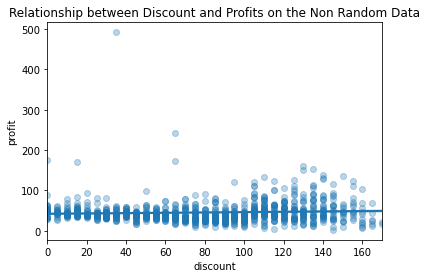

In [11]:
np.random.seed(123) # for reproducibility
sns.regplot(data = train.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relationship between Discount and Profits on the Non Random Data");

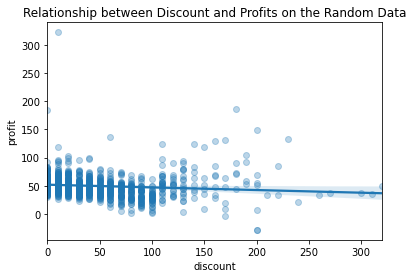

In [12]:
np.random.seed(123) # for reproducibility
sns.regplot(data = test.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relationship between Discount and Profits on the Random Data");

The first plot shows a positive relationship between discount and profits. We cannot say this relationship is causal, because there might be confounding variables that were unaccounted for.
 
As for the second plot, it shows a negative relationship between discount and profits. Since discount was randomly assigned in this dataset, we can say that this relationship captures the causal effect of discount on profits.

### Step 4

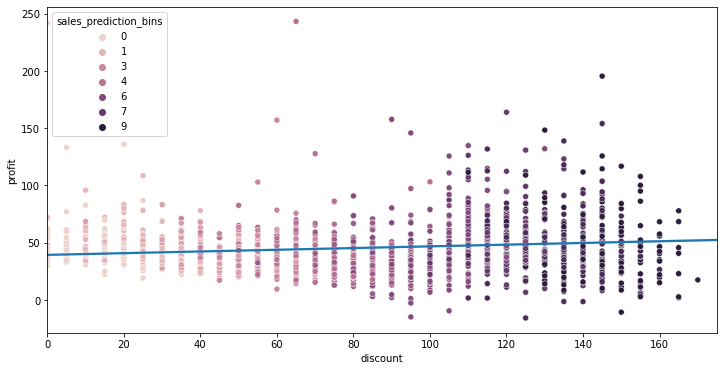

In [10]:
plt.figure(figsize=(12,6))
plt_sample = train.sample(2000)
sns.scatterplot(data=plt_sample, x="discount", y="profit", hue="sales_prediction_bins")
sns.regplot(x="discount", y="profit", data=train, scatter=False);

The relationship between profit and discount seems to be positive. We probably can't interpret this relationship as causal, because customers with higher discounts also have higher sales predictions. Hence
 
$$
E[Profit_0|Discount=High] >  E[Profit_0|Discount=Low]
$$
 
In other words, high discount customers would still buy more than low discount customers even in the absence of high discounts. 

## Milestone 2

### Step 1

In [11]:
full_model = smf.ols("profit~discount+C(sales_prediction_bins)", data=train).fit()

full_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,45.1995,0.616,73.397,0.000,43.992,46.407
C(sales_prediction_bins)[T.1],0.3418,0.858,0.399,0.690,-1.339,2.023
C(sales_prediction_bins)[T.2],-1.7348,0.964,-1.799,0.072,-3.625,0.156
C(sales_prediction_bins)[T.3],-3.5352,1.102,-3.209,0.001,-5.694,-1.376
C(sales_prediction_bins)[T.4],-4.9727,1.294,-3.842,0.000,-7.510,-2.436
C(sales_prediction_bins)[T.5],-5.4330,1.484,-3.661,0.000,-8.342,-2.524
C(sales_prediction_bins)[T.6],0.9766,1.723,0.567,0.571,-2.400,4.353
C(sales_prediction_bins)[T.7],9.7498,1.921,5.075,0.000,5.984,13.515
C(sales_prediction_bins)[T.8],11.9732,2.187,5.475,0.000,7.687,16.260
C(sales_prediction_bins)[T.9],11.8579,2.393,4.954,0.000,7.167,16.549


After controlling for `sales_prediction_bins`, we find that discount has a negative impact on profits. Another way of saying this is that we estimate profits to go down as discount increases, **while holding `sales_prediction_bins` fixed.** This is shown by the negative coefficient of -0.024 associated with discount.


### Step 2

In [12]:
debias_model = smf.ols("discount~C(sales_prediction_bins)", data=train).fit()

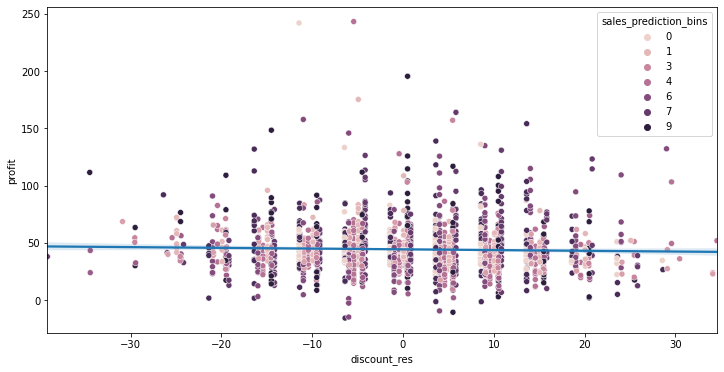

In [13]:
plt_sample_debiased = plt_sample.assign(discount_res = plt_sample["discount"] - debias_model.predict(plt_sample))

plt.figure(figsize=(12,6))
sns.scatterplot(data=plt_sample_debiased, x="discount_res", y="profit", hue="sales_prediction_bins")
sns.regplot(x="discount_res", y="profit", data=plt_sample_debiased, scatter=False);

### Step 3

In [14]:
denoise_model = smf.ols("profit~C(sales_prediction_bins)", data=train).fit()

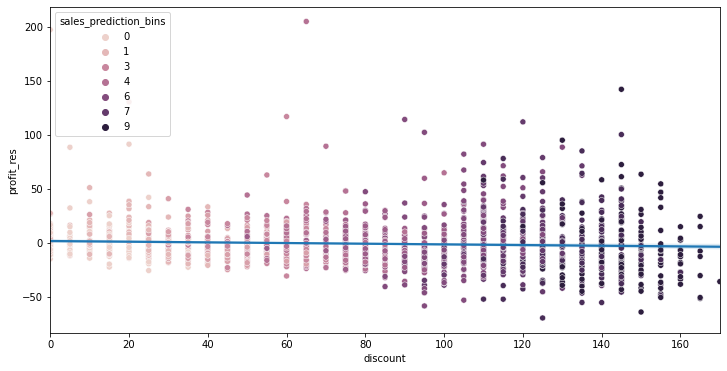

In [15]:
plt_sample_denoise = plt_sample.assign(profit_res = plt_sample["profit"]- denoise_model.predict(plt_sample))

plt.figure(figsize=(12,6))
sns.scatterplot(data=plt_sample_denoise, x="discount", y="profit_res", hue="sales_prediction_bins")
sns.regplot(x="discount", y="profit_res", data=plt_sample_denoise, scatter=False);

It's hard to see from the plot, but if we show the variance for profits and profit residuals, we can see that the latter has smaller variance. That is because some variance was explained away by using `sales_prediction_bin`

In [16]:
denoise_model.resid.var(), train["profit"].var()

(512.5731256022972, 545.4015163032522)

### Step 4

In [17]:
train_res = train.assign(profit_res = denoise_model.resid,
                         discount_res = debias_model.resid)



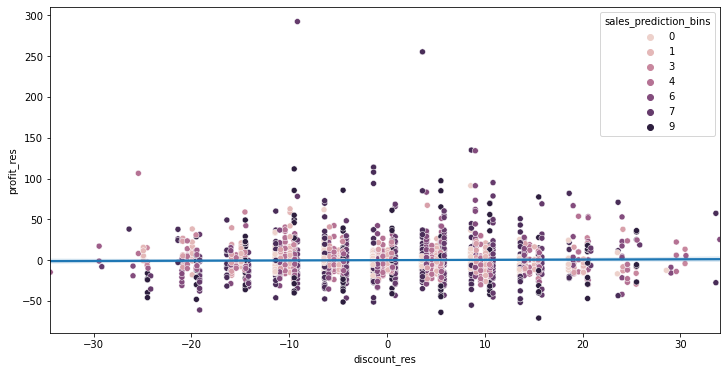

In [18]:
plt_sample_res = train_res.sample(2000)

plt.figure(figsize=(12,6))
sns.scatterplot(data=plt_sample_res, x="discount_res", y="profit_res", hue="sales_prediction_bins")
sns.regplot(x="discount_res", y="profit_res", data=plt_sample_res, scatter=False);

### Step 5

In [19]:
final_model = smf.ols("profit_res~discount_res", data=train_res).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.807e-14,0.185,-9.77e-14,1.000,-0.362,0.362
discount_res,-0.0247,0.017,-1.464,0.143,-0.058,0.008


In [20]:
full_model.params["discount"]

-0.024708440853956716

The coefficient with breaking the regression into the FWL steps is exactly the same as the one we got from regressing discount on `sales_prediction_bin` and discount at the same time. This is not a surprising fact, as it is precisely what the FWL theorem tells us. 
 


## Milestone 3

### Step 1

In [21]:
avg_sales_per_state = train.groupby("cust_state").mean()["sales"].to_dict()

def state_to_numeric(df):
    return df.assign(cust_state_num = df["cust_state"].replace(avg_sales_per_state))

In [22]:
train_processed = state_to_numeric(train)
train_processed.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,sales,discount,profit,age,gender,cust_state,tenure,sales_prediction_bins,sales_prediction,cust_state_num
0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,3368.64,125.0,40.06,40,1.0,MA,6,8,1351.024765,2579.424297
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,2133.10,75.0,29.52,36,0.0,MG,10,4,1035.580387,2553.222774
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,2001.62,50.0,48.08,34,0.0,RJ,7,3,992.401825,2518.635848
3,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,1461.96,10.0,61.64,31,0.0,BA,7,1,919.720735,2446.648394
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,2743.72,100.0,34.44,32,1.0,PB,6,6,1176.485681,2562.461439


### Step 2

In [23]:
from sklearn.model_selection import cross_val_predict

not_features = ["sales", "profit", "cust_state", "discount"]

X = list(train_processed.drop(columns=not_features).columns)
T = "discount"

np.random.seed(123)

debias_m = LGBMRegressor(max_depth=3)
t_res = train[T] - cross_val_predict(debias_m, train_processed[X], train_processed[T], cv=5)

train_debiased = train_processed.assign(discount_res = t_res)

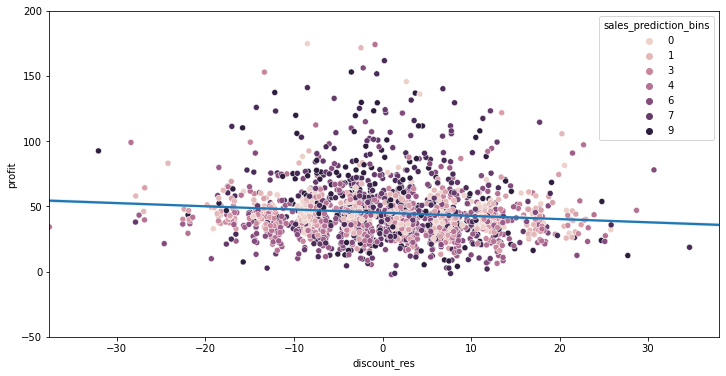

In [24]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=train_debiased.sample(2000), x="discount_res", y="profit", hue="sales_prediction_bins")
sns.regplot(x="discount_res", y="profit", data=train_debiased, scatter=False)
plt.ylim(-50, 200);

Once we implement the debiasing step in FWL, using machine learning models, we can see that the bias diminishes. We are now able to find a negative relationship between discount and sales, which is more in line with the results we saw in previous milestones. However, we can see that the bias is not completely gone, as customers with low sales predictions (sales_prediction_bins=0 and 1) are still concentrated in the low discount regions. So, low and high discount customers are still not 100% comparable. 
 


### Step 3

In [25]:
Y = "profit"

np.random.seed(123)

denoise_m = LGBMRegressor(max_depth=3)

y_res = train[Y] - cross_val_predict(debias_m, train_processed[X], train_processed[Y], cv=5)

train_denoised = train_debiased.assign(profit_res = y_res)

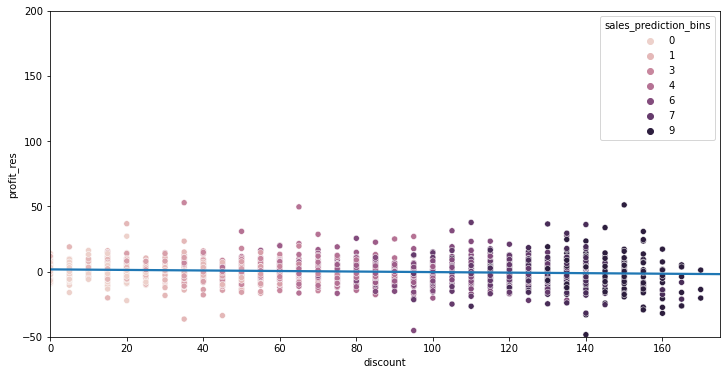

In [26]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=train_denoised.sample(2000), x="discount", y="profit_res", hue="sales_prediction_bins")
sns.regplot(x="discount", y="profit_res", data=train_denoised, scatter=False)
plt.ylim(-50, 200);

The denoising step in the FWL theorem doesn't change the direction of the relationship between discount and profits. However, it significantly reduces variance in the outcome variable (profit), making the relationship between discount and profit more apparent. 
 
Another thing to notice is that this denoising and debiasing procedure made the data centered at zero. This is expected, but it makes interpretation harder. One possible workaround is to add the overall discount and profit averages to their respective residualized versions. 

### Step 4

In [27]:
final_model = smf.ols("profit_res~discount_res", data=train_denoised).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0531,0.072,0.737,0.461,-0.088,0.194
discount_res,-0.2369,0.008,-30.039,0.000,-0.252,-0.221


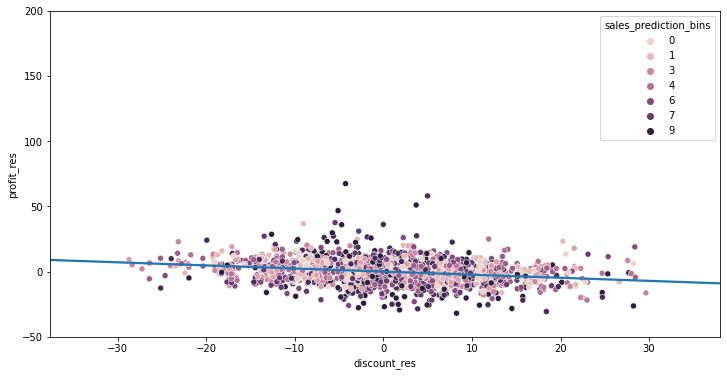

In [28]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=train_denoised.sample(2000), x="discount_res", y="profit_res", hue="sales_prediction_bins")
sns.regplot(x="discount_res", y="profit_res", data=train_denoised, scatter=False)
plt.ylim(-50, 200);

Just like when we controlled for `sales_prediction_bins` when using regression to estimate the impact of discount on profits, using Double/Debiased ML also yielded a negative coefficient. It looks like increasing the discount in one unit will decrease profits by about 0.23 units.

## Milestone 4

### Step 1

In [29]:
# create the weights
w = train_denoised[f"{T}_res"] ** 2 
 
# create the transformed target
y_star = (train_denoised[f"{Y}_res"] / train_denoised[f"{T}_res"])
 

### Step 2

In [45]:
not_features_final_model = ["sales", "profit", "cust_state", "discount", "sales_prediction", "sales_prediction_bins"]
X_final_model = list(train_processed.drop(columns=not_features_final_model).columns)


model_final = LGBMRegressor(max_depth=3)
 

# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train_denoised[X_final_model], y=y_star, sample_weight=w);

In [31]:
test_pred = test.assign(cate=model_final.predict(test.pipe(state_to_numeric)[X_final_model]))

test_pred.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_5m_eletronic,spend_6m_eletronic,sales,discount,age,gender,cust_state,tenure,profit,cate
0,0,0,0,0,0,0.0,25,50.0,0.0,0.0,...,0.0,0.0,1503.22,20.0,35,1.0,MA,23,55.16,-0.176512
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,1798.30,60.0,29,1.0,MG,18,29.92,-0.275934
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,1122.97,0.0,30,1.0,RJ,20,56.15,-0.275934
3,10,15,0,25,10,0.0,0,0.0,0.0,0.0,...,0.0,0.0,1217.08,10.0,32,0.0,BA,20,50.85,-0.148154
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,966.58,0.0,30,0.0,PB,22,48.33,-0.295166


### Step 3

In [32]:
def elast(data, t, y):
    cov_matrix = np.cov(data[y], data[t])
    return cov_matrix[1, 0] / cov_matrix[1, 1]

In [33]:
def cumulative_elast_curve(dataset, prediction, y, t, min_periods=30, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), t, y) for rows in n_rows])


In [34]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), t, y) * (rows/size) for rows in n_rows])


### Step 4

In [35]:
cum_elast_cate = cumulative_elast_curve(test_pred, "cate", y="profit", t="discount")
cum_elast_age = cumulative_elast_curve(test_pred, "age", y="profit", t="discount")

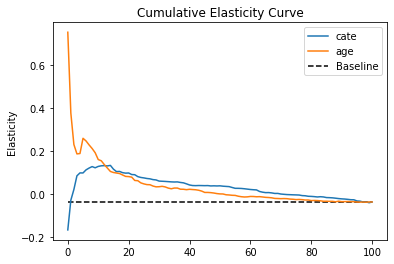

In [41]:
plt.plot(cum_elast_cate, label="cate")
plt.plot(cum_elast_age, label="age")
plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Baseline")
plt.ylabel("Elasticity")
plt.title("Cumulative Elasticity Curve")
plt.legend();

 The cumulative elasticity curve shows that our treatment effect (TE) model starts further from the ATE and converges slowlier to it. This means that the model is better at distinguishing customers with high TE from those with low TE. It looks better than simply using Age, but not by much. 


In [42]:
gain_cate = cumulative_gain(test_pred, "cate", y="profit", t="discount", ascending=False)
gain_age = cumulative_gain(test_pred, "age", y="profit", t="discount", ascending=False)

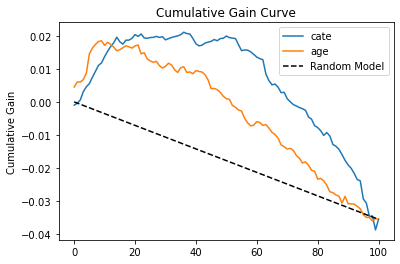

In [43]:
plt.plot(gain_cate, label="cate")
plt.plot(gain_age, label="age")

plt.plot([0, 100], [0, elast(test_pred, "discount", "profit")], linestyle="--", label="Random Model", color="black")

plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve")
plt.legend();

The cumulative gain curve tells a different story. While simply ordering by Age is better at distinguishing customers with a very positive treatment effect (the age curve starts above out model’s curve), our model is clearly better than simply using age to distinguish between customers with low and high treatment effects. 

### Step 5

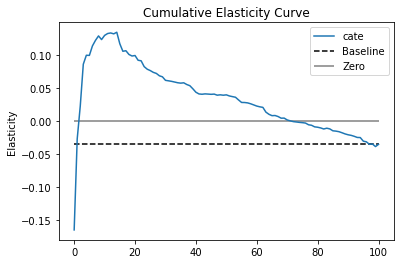

In [44]:
plt.plot(cum_elast_cate, label="cate")
plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Baseline")
plt.hlines(0, 0, 100, linestyle="-", color="Grey", label="Zero")
plt.ylabel("Elasticity")
plt.title("Cumulative Elasticity Curve")
plt.legend();

In [51]:
np.quantile(test_pred["cate"], 0.5)

-0.2045657177731919

The cumulative elasticity curve says that, if we sort customers according to our treatment effect model, the top 60% of customers would all have a positive treatment effect. This means that, if we increase the discount for them, we would also increase profits. To add some conservatism to our recommendation, we could say that the e-commerce company should give discounts to whomever has a TE prediction above the 50 percentile